# Silver Analytics - Austin Airbnb

Análise dos dados tratados da camada Silver (PostgreSQL) - 12 Gráficos.

Analisar dados já tratados e compará-los com os brutos para checagem.

### Configuração do ambiente
- **Objetivo:** preparar ambiente visual e conectar ao banco de dados.
- **Ações:** aplica tema gráfico e carrega dados do PostgreSQL.
- **Saída:** dataframes prontos para análise.

Verificar dependências e credenciais de acesso ao banco.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine

plt.style.use('seaborn-v0_8')
sns.set_theme(context="notebook", style="whitegrid")

### Conexão com o banco de dados

Ajustar credenciais, testar conexão e garantir permissões de leitura.

In [ ]:
DB_CONFIG = {
    'host': 'localhost',
    'port': '5432',
    'database': 'austin_airbnb',
    'user': 'postgres',
    'password': 'postgres'
}

engine = create_engine(
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@"
    f"{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

print("Conectado ao PostgreSQL!")

Conectado ao PostgreSQL!


### Carregamento dos dados

Executar consultas SQL para extrair tabelas e validar volumes retornados.

In [9]:
query_listings = """
SELECT DISTINCT 
    listing_id, listing_name, property_type, room_type, bed_type,
    accommodates, bathrooms, bedrooms, beds,
    neighbourhood_cleansed, listing_price as price,
    number_of_reviews, first_review, last_review
FROM silver.one_big_table
"""
df_listings = pd.read_sql(query_listings, engine)

query_calendar = """
SELECT DISTINCT
    listing_id, calendar_date as date, calendar_available as available
FROM silver.one_big_table
"""
df_calendar = pd.read_sql(query_calendar, engine)

query_reviews = """
SELECT DISTINCT
    review_id, listing_id, review_date as date, reviewer_id, reviewer_name
FROM silver.one_big_table
WHERE review_id IS NOT NULL
"""
df_reviews = pd.read_sql(query_reviews, engine)

print(f"Listings: {len(df_listings):,} registros")
print(f"Calendar: {len(df_calendar):,} registros")
print(f"Reviews: {len(df_reviews):,} registros")

Listings: 5,244 registros
Calendar: 234,597 registros
Reviews: 21,192 registros


## Gráfico 1: Gráfico de Barras - Top 10 Tipos de Propriedade

Visualizar top 10 tipos de propriedade a partir da camada Silver.

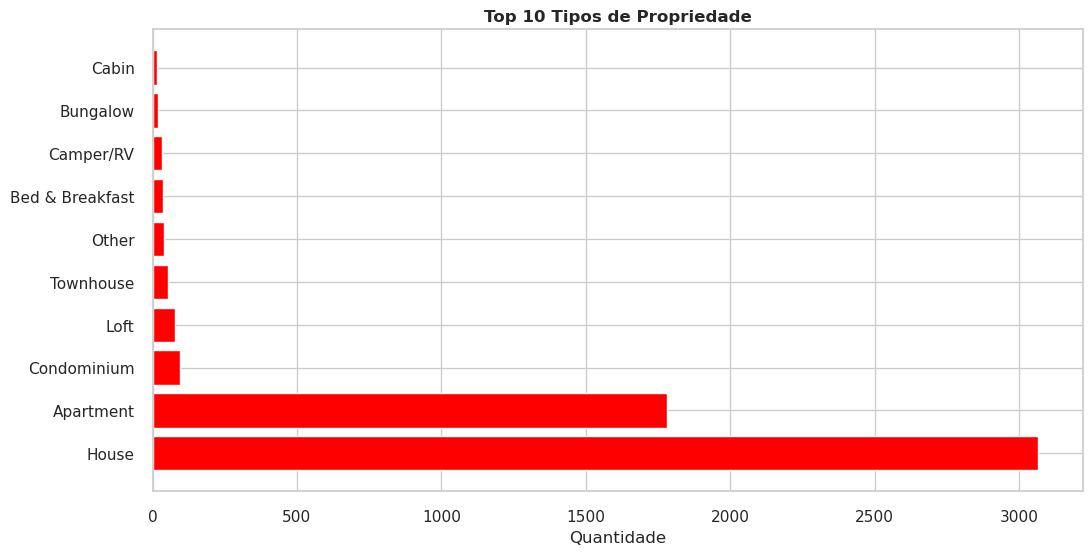

In [10]:
prop_counts = df_listings['property_type'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(prop_counts)), prop_counts.values, color='#f00')
ax.set_yticks(range(len(prop_counts)))
ax.set_yticklabels(prop_counts.index)
ax.set_xlabel('Quantidade')
ax.set_title('Top 10 Tipos de Propriedade', fontweight='bold')
plt.show()

## Gráfico 2: Gráfico de Pizza - Distribuição de Tipos de Quarto

Checar proporções de tipos de quarto após o tratamento.

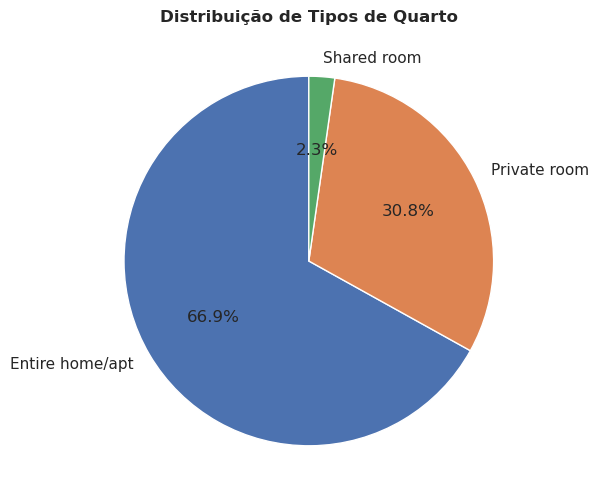

In [11]:
room_dist = df_listings['room_type'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(room_dist.values, labels=room_dist.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribuição de Tipos de Quarto', fontweight='bold')
plt.show()

## Gráfico 3: Gráfico de Barras - Disponibilidade no Calendar

Avaliar disponibilidade agregada usando dados carregados no Silver.

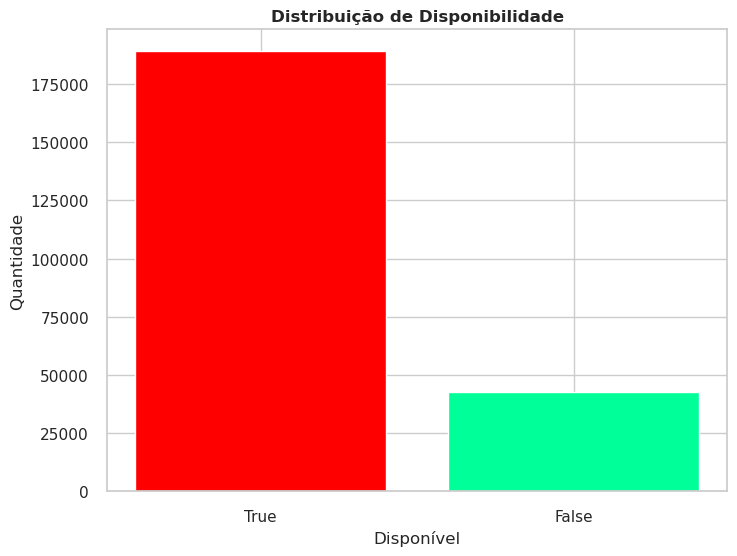

In [12]:
avail_dist = df_calendar['available'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(avail_dist.index.astype(str), avail_dist.values, color=['#f00', '#0f9'])
ax.set_xlabel('Disponível')
ax.set_ylabel('Quantidade')
ax.set_title('Distribuição de Disponibilidade', fontweight='bold')
plt.show()

## Gráfico 4: Histograma - Distribuição de Preços

Analisar distribuição de preços e identificar diferenças vs dados brutos.

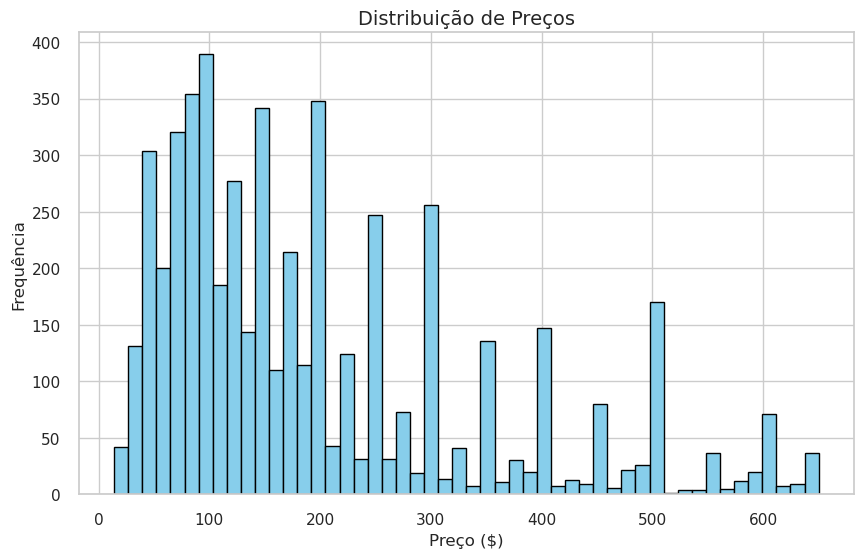

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df_listings['price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribuição de Preços', fontsize=14)
plt.xlabel('Preço ($)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

## Gráfico 5: Gráfico de Linha - Reviews ao Longo do Tempo

Ver tendência de reviews usando os registros consolidados no Silver.

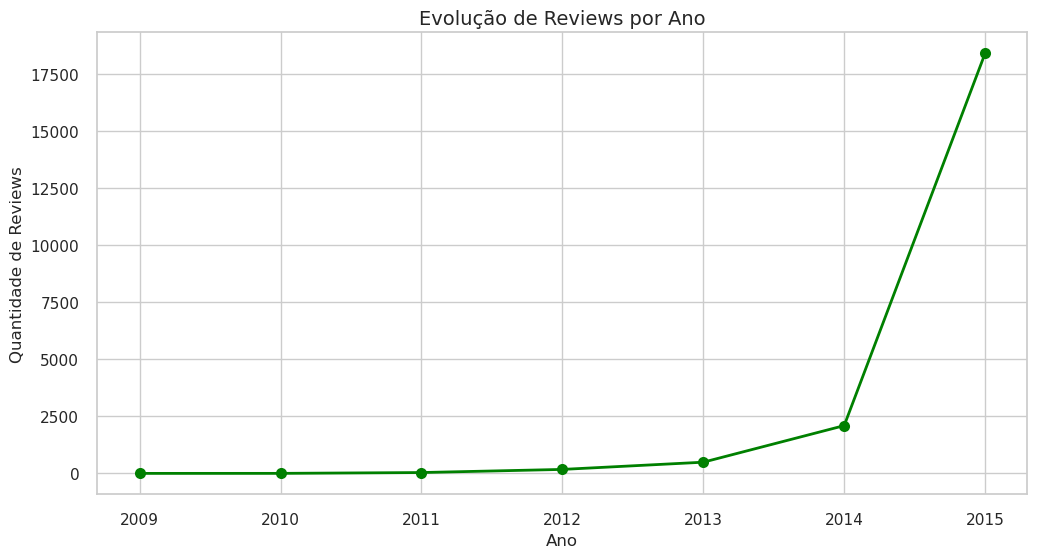

In [14]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_reviews['year'] = df_reviews['date'].dt.year
reviews_by_year = df_reviews['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(reviews_by_year.index, reviews_by_year.values, marker='o', color='green', linewidth=2, markersize=8)
plt.title('Evolução de Reviews por Ano', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade de Reviews', fontsize=12)
plt.show()

## Gráfico 6: Gráfico de Barras - Reviews por Ano

Comparar contagem de reviews por ano para detectar padrões.

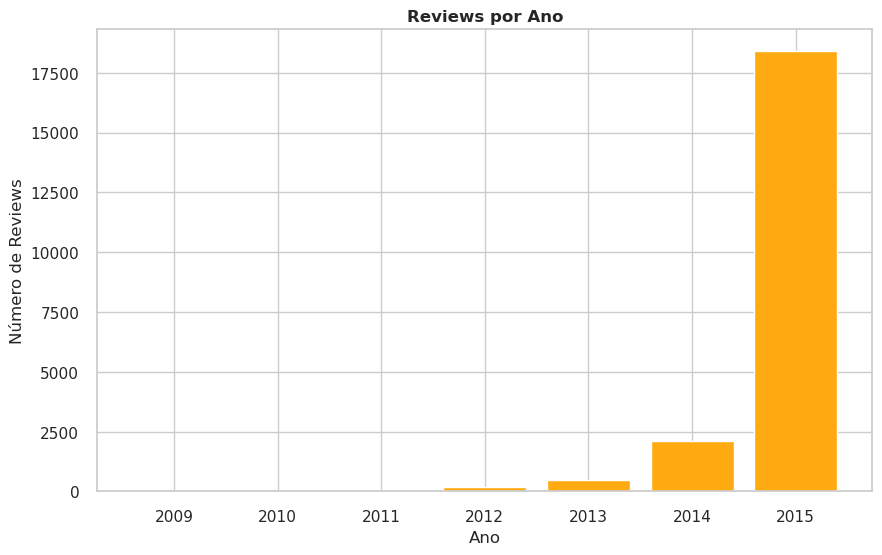

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(reviews_by_year.index, reviews_by_year.values, color='#fa1')
ax.set_xlabel('Ano')
ax.set_ylabel('Número de Reviews')
ax.set_title('Reviews por Ano', fontweight='bold')
plt.show()

## Gráfico 7: Gráfico de Barras - Top 10 Bairros

Identificar bairros com mais anúncios na camada tratada.

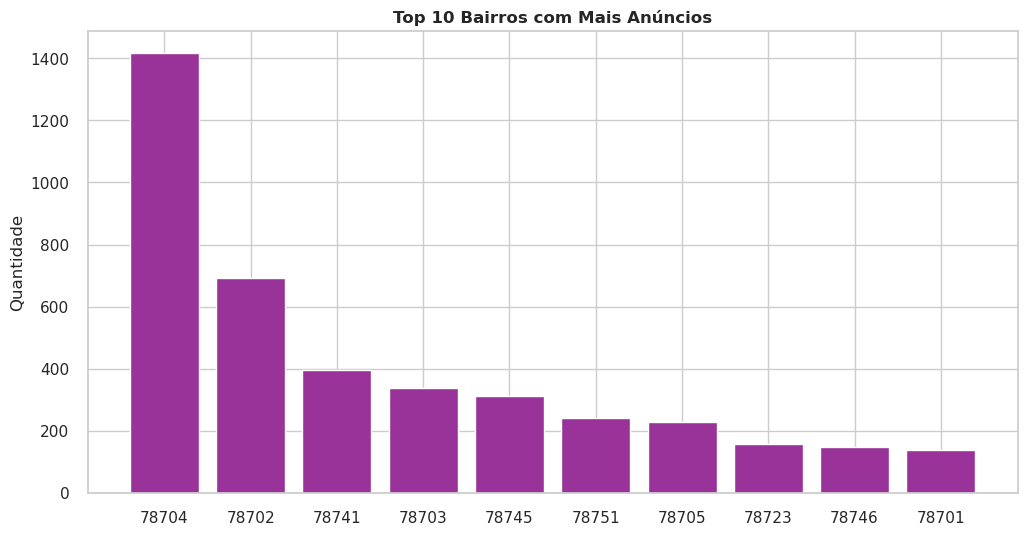

In [16]:
neigh_counts = df_listings['neighbourhood_cleansed'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(neigh_counts)), neigh_counts.values, color='#993399')
ax.set_xticks(range(len(neigh_counts)))
ax.set_xticklabels(neigh_counts.index)
ax.set_ylabel('Quantidade')
ax.set_title('Top 10 Bairros com Mais Anúncios', fontweight='bold')
plt.show()

## Gráfico 8: BoxPlot - Distribuição de Preços por Tipo de Quarto

Comparar dispersões de preço entre tipos de quarto .

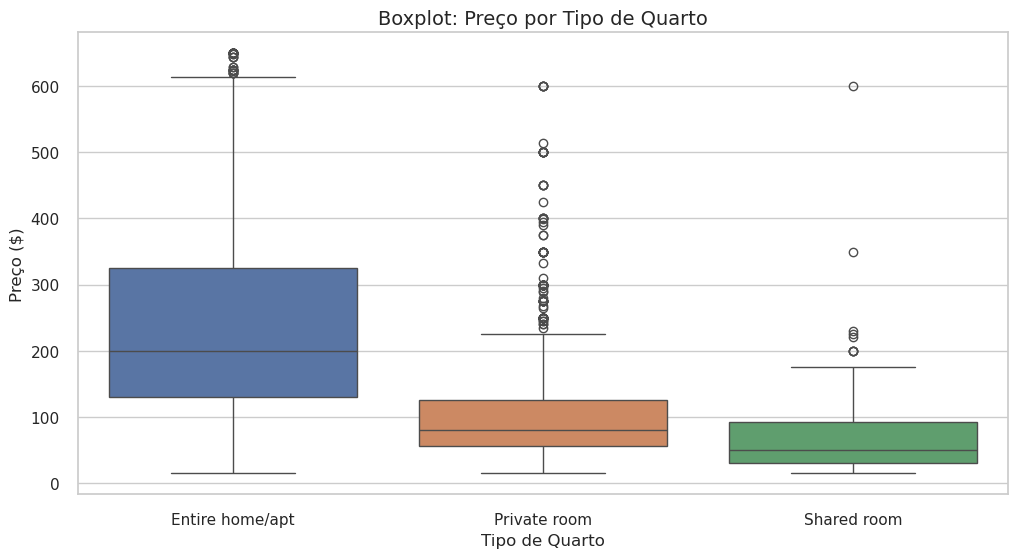

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_listings, x='room_type', y='price', hue='room_type', legend=False)
plt.title('Boxplot: Preço por Tipo de Quarto', fontsize=14)
plt.xlabel('Tipo de Quarto', fontsize=12)
plt.ylabel('Preço ($)', fontsize=12)
plt.show()

## Gráfico 9: Matriz de Confusão - Tipo de Quarto vs Faixa de Preço

Avaliar relação entre tipo de quarto e categorias de preço.

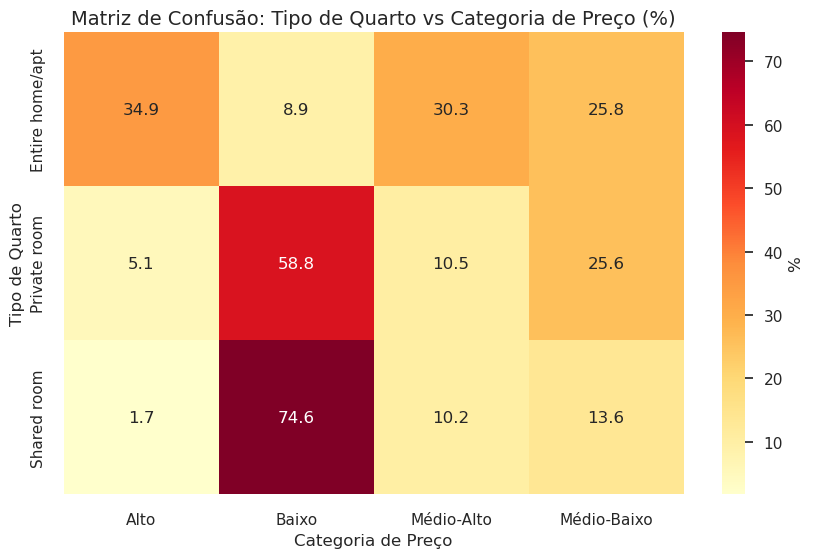

In [18]:
df_conf = df_listings[['room_type', 'price']].copy()
quartiles = df_conf['price'].quantile([0.25, 0.5, 0.75])


def categorize_price(price):
    if price <= quartiles[0.25]:
        return 'Baixo'
    elif price <= quartiles[0.5]:
        return 'Médio-Baixo'
    elif price <= quartiles[0.75]:
        return 'Médio-Alto'
    else:
        return 'Alto'

df_conf['price_category'] = df_conf['price'].apply(categorize_price)

confusion = pd.crosstab(df_conf['room_type'], df_conf['price_category'], normalize='index') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': '%'})
plt.title('Matriz de Confusão: Tipo de Quarto vs Categoria de Preço (%)', fontsize=14)
plt.xlabel('Categoria de Preço', fontsize=12)
plt.ylabel('Tipo de Quarto', fontsize=12)
plt.show()

## Gráfico 10: Regressão Linear - Preço vs Número de Reviews

Ajustar regressão para investigar correlação preço x reviews .

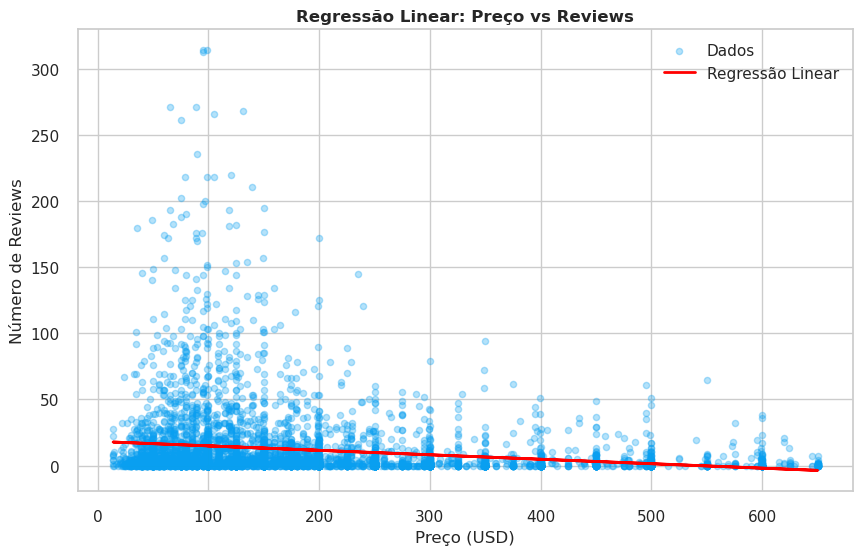

In [19]:
df_reg = df_listings[['price', 'number_of_reviews']].copy()

x = df_reg[['price']]
y = df_reg['number_of_reviews']

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, alpha=0.3, s=20, color='#099ff0', label='Dados')
ax.plot(x, y_pred, color='red', linewidth=2, label='Regressão Linear')
ax.set_xlabel('Preço (USD)')
ax.set_ylabel('Número de Reviews')
ax.set_title('Regressão Linear: Preço vs Reviews', fontweight='bold')
ax.legend()
plt.show()